<h1 align="center">K-means Clustering Model</h1>

## Overview

This project involves working as a consultant for a scientific organization dedicated to supporting and sustaining penguin colonies. The goal is to help staff members better understand penguin populations by analyzing important biological and environmental characteristics.

The dataset used for this analysis contains a sample of 345 penguins. Each row represents a single penguin and includes variables such as species, island, sex, and other recorded characteristics. A K means clustering model is applied to this dataset to identify patterns that may offer meaningful insights into penguin populations and their differences.

## Executive Summary

This analysis applies a K-means clustering model to explore patterns within a dataset of 345 penguins. The dataset includes information such as species, island, and sex, which are used to uncover natural groupings among the penguins. Visualizations from the clustering results indicate that clusters are clearly differentiated by species and by sex, particularly by the variable representing male penguins.

The elbow plot suggests a possible inflection point at six clusters, but this method alone does not conclusively determine an optimal number of clusters. Therefore, silhouette scores are examined to provide additional confirmation. The silhouette analysis shows that the highest score occurs when the data is grouped into six clusters, with five clusters also producing reasonably high values.

The results indicate that a six cluster solution provides meaningful separation between groups. This aligns with existing research suggesting sexual dimorphism across the three penguin species. Since each species has two sexes, a six cluster model appropriately captures these distinctions.

## Data & Methodology

The dataset consists of 345 penguin observations, each containing attributes such as species, island, and sex. These variables allow for an in depth examination of how penguins differ both across species and between sexes. The purpose of the analysis is to use unsupervised learning to uncover natural structure within the data rather than predicting a specific outcome.

K-means clustering is employed for this task because it is a widely used method for grouping observations based on similarity across multiple variables. The model attempts to partition the penguins into a specified number of clusters in a way that minimizes the variance within each group.

### Import packages

In [5]:
# Standard operational packages
import numpy as np
import pandas as pd

# Modeling and evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Load and preview the dataset

In [6]:
penguins = pd.read_csv("penguins.csv")
penguins.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


## Exploratory Data Analysis (EDA)

In [7]:
# Penguin types
penguins['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [8]:
# Count of each species type
penguins['species'].value_counts(dropna = False)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

There are three types of species. Note the Chinstrap species is less common than the other species. This has a chance to affect K-means clustering as K-means performs best with similar sized groupings.

For purposes of clustering, we'll pretend we don't know that there are three different types of species. Then, we can explore whether the algorithm can discover the different species and find other relationships in the data.

### Check for missing values

An assumption of K-means is that there are no missing values.

In [9]:
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [10]:
# Drop rows with missing values.
penguins_subset = penguins.dropna(axis=0).reset_index(drop = True)

### Encode data

Some versions of the penguins dataset have values encoded in the `'sex'` column as 'Male' and 'Female' instead of 'MALE' and 'FEMALE'. 

In [11]:
penguins_subset['sex'] = penguins_subset['sex'].str.upper()

K-means needs numeric columns for clustering. We'll convert the categorical column `'sex'` into numeric. There is no need to convert the `'species'` column because it isn't being used as a feature in the clustering algorithm. 

In [12]:
# Convert `sex` column from categorical to numeric.
penguins_subset = pd.get_dummies(penguins_subset, drop_first = True, columns=['sex'])

### Drop a column

Drop the categorical column `island` from the dataset. While it has value, this notebook is trying to confirm if penguins of the same species exhibit different physical characteristics based on sex. This doesn't include location.

Note that the `'species'` column is not numeric. We won't don't drop the `'species'` column for now because it could potentially be used to help understand the clusters later. 

In [13]:
# Drop the island column.
penguins_subset = penguins_subset.drop(['island'], axis=1)

### Scale the features

Because K-means uses distance between observations as its measure of similarity, it's important to scale the data before modeling. This ensures that all variables have a mean of 0 and variance/standard deviation of 1. 

Because the species column isn't a feature, it doesn't need to be scaled.

In [14]:
# Exclude `species` variable from X
X = penguins_subset.drop(['species'], axis=1)

# Scale the features and assign the scaled data to a new variable.
X_scaled = StandardScaler().fit_transform(X)

## Model Development

Now, fit K-means and evaluate inertia for different values of k. Because we may not know how many clusters exist in the data, we'll start by fitting K-means and examining the inertia values for different values of k. To do this, we'll write a function called `kmeans_inertia` that takes in `num_clusters` and `x_vals` (`X_scaled`) and returns a list of each k-value's inertia.

When using K-means inside the function, we'll set the `random_state` to `42`. This way, others can reproduce these results.

In [15]:
# Fit K-means and evaluate inertia for different values of k.
num_clusters = [i for i in range(2, 11)]

def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints. 
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

Use the `kmeans_inertia` function to return a list of inertia for k=2 to 10.

In [16]:
# Return a list of inertia for k=2 to 10.
inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

[885.6224143652253,
 578.8284278107237,
 477.2295673528196,
 284.5464837898291,
 218.05156297830223,
 201.51585567445807,
 196.58908645819528,
 180.65751845628574,
 170.157035897555]

Next, we'll create a line plot that shows the relationship between `num_clusters` and `inertia`.

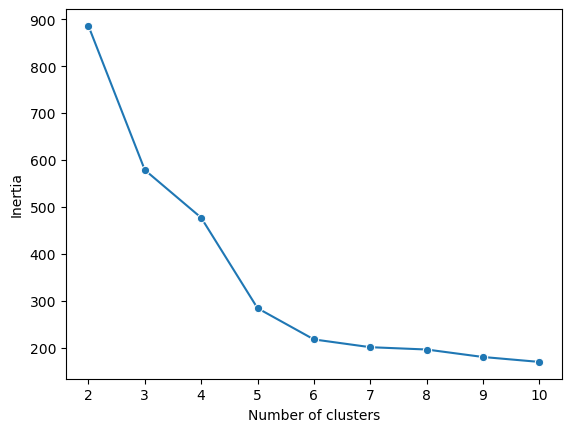

In [17]:
# Create a line plot.
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

The plot seems to depict an elbow at six clusters, but there isn't a clear method for confirming that a six-cluster model is optimal. Therefore, the silhouette scores should be checked. 

## Model Results & Interpretation

Now, we'll evaluate the silhouette score using the `silhouette_score()` function. Silhouette scores are used to study the distance between clusters.
Then we'll compare the silhouette score of each value of k, from 2 through 10. To do this, we'll write a function called `kmeans_sil` that takes in `num_clusters` and `x_vals` (`X_scaled`) and returns a list of each k-value's silhouette score.

In [18]:
# Evaluate silhouette score and return a list of each k-value's score.

def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value. 
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score

sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score

[np.float64(0.44398088353055243),
 np.float64(0.45101024097188375),
 np.float64(0.4489699212061028),
 np.float64(0.5199985748608681),
 np.float64(0.5223086008347771),
 np.float64(0.47386350642293157),
 np.float64(0.4715443426463867),
 np.float64(0.4160561489496056),
 np.float64(0.4183063433691049)]

Next, we'll create a line plot that shows the relationship between `num_clusters` and `sil_score`.

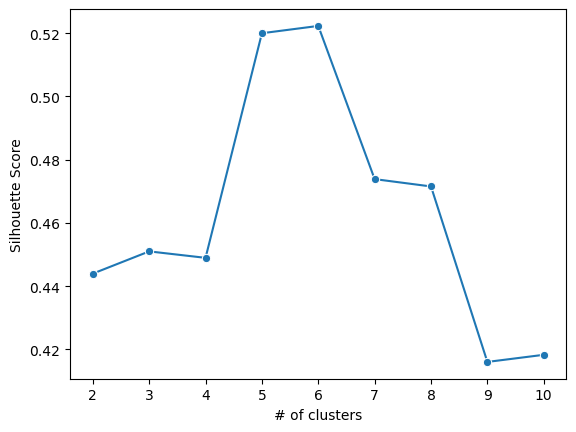

In [19]:
# Create a line plot.
plot = sns.lineplot(x=num_clusters, y=sil_score, marker = 'o')
plot.set_xlabel("# of clusters");
plot.set_ylabel("Silhouette Score");

Silhouette scores near 1 indicate that samples are far away from neighboring clusters. Scores close to 0 indicate that samples are on or very close to the decision boundary between two neighboring clusters.

The plot indicates that the silhouette score is closest to 1 when the data is partitioned into six clusters, although five clusters also yield a relatively good silhouette score.

### Optimal k-value

To decide on an optimal k-value, fit a six-cluster model to the dataset. 

In [20]:
# Fit a 6-cluster model.
kmeans6 = KMeans(n_clusters=6, random_state=42)
kmeans6.fit(X_scaled)

KMeans(n_clusters=6, random_state=42)

Print out the unique labels of the fit model.

In [21]:
# Print unique labels.
print('Unique labels:', np.unique(kmeans6.labels_))

Unique labels: [0 1 2 3 4 5]


Now, we'll create a new column `cluster` that indicates cluster assignment in the DataFrame `penguins_subset`. It's important to understand the meaning of each cluster's labels, then decide whether the clustering makes sense. 

**Note:** This task is done using `penguins_subset` because it is often easier to interpret unscaled data.

In [22]:
# Create a new column `cluster`.
penguins_subset['cluster'] = kmeans6.labels_
penguins_subset.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,cluster
0,Adelie,39.1,18.7,181.0,3750.0,True,5
1,Adelie,39.5,17.4,186.0,3800.0,False,2
2,Adelie,40.3,18.0,195.0,3250.0,False,2
3,Adelie,36.7,19.3,193.0,3450.0,False,2
4,Adelie,39.3,20.6,190.0,3650.0,True,5


Use `groupby` to verify if any `'cluster'` can be differentiated by `'species'`.

In [23]:
# Verify if any `cluster` can be differentiated by `species`.
penguins_subset.groupby(by=['cluster', 'species']).size()

cluster  species  
0        Chinstrap    32
1        Gentoo       58
2        Adelie       73
         Chinstrap     2
3        Adelie        2
         Chinstrap    34
4        Gentoo       61
5        Adelie       71
dtype: int64

Next, we'll interpret the groupby outputs. Although the results of the groupby show that each `'cluster'` can be differentiated by `'species'`, it is useful to visualize these results. The graph shows that each `'cluster'` can be differentiated by `'species'`. 

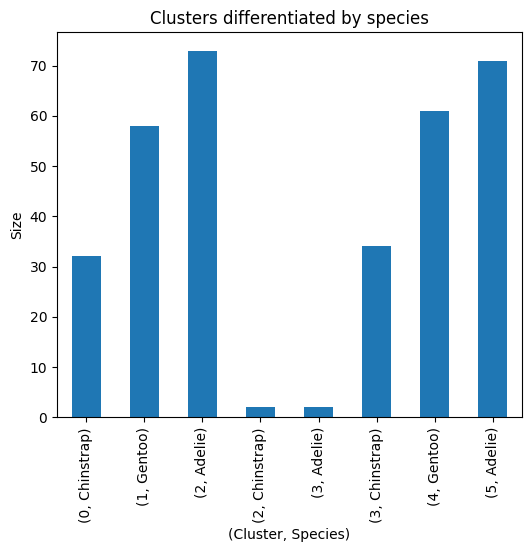

In [24]:
penguins_subset.groupby(by=['cluster', 'species']).size().plot.bar(title='Clusters differentiated by species',
                                                                   figsize=(6, 5),
                                                                   ylabel='Size',
                                                                   xlabel='(Cluster, Species)');

Use `groupby` to verify if each `'cluster'` can be differentiated by `'species'` AND `'sex_MALE'`.

In [25]:
# Verify if each `cluster` can be differentiated by `species' AND `sex_MALE`.
penguins_subset.groupby(by=['cluster','species', 'sex_MALE']).size().sort_values(ascending = False)

cluster  species    sex_MALE
2        Adelie     False       73
5        Adelie     True        71
4        Gentoo     True        61
1        Gentoo     False       58
3        Chinstrap  True        34
0        Chinstrap  False       32
2        Chinstrap  False        2
3        Adelie     True         2
dtype: int64

Even though clusters 1 and 3 weren't all one species or sex, the `groupby` indicates that the algorithm produced clusters mostly differentiated by species and sex. 

The graph shows that each `'cluster'` can be differentiated by `'species'` and `'sex_MALE'`. Furthermore, each cluster is mostly comprised of one sex and one species.

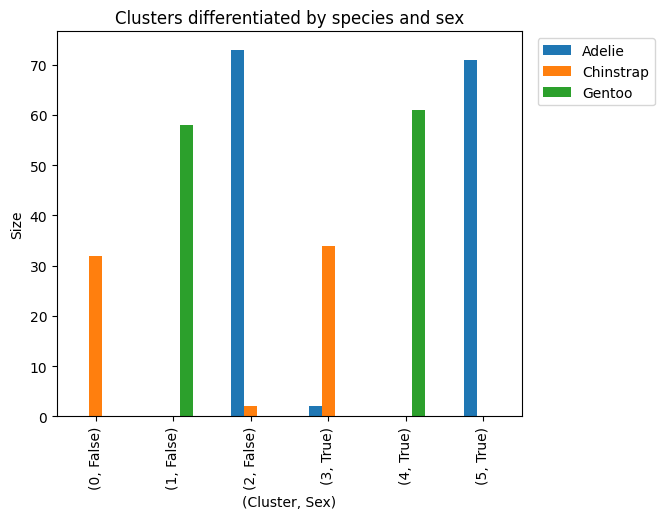

In [26]:
penguins_subset.groupby(by=['cluster','species','sex_MALE']).size().unstack(level = 'species', fill_value=0).plot.bar(title='Clusters differentiated by species and sex',
                                                                                                                      figsize=(6, 5),
                                                                                                                      ylabel='Size',
                                                                                                                      xlabel='(Cluster, Sex)')
plt.legend(bbox_to_anchor=(1.3, 1.0))

## Next Steps

- Conduct further exploratory data analysis to identify additional variables that may strengthen cluster separation and provide deeper insight into differences across penguin species and sexes.

- Validate the six cluster model by testing alternative clustering methods such as hierarchical clustering or Gaussian mixture models to determine whether similar group distinctions emerge.

- Expand the dataset by collecting additional biological and environmental measurements from field teams so that clusters can be evaluated across broader conditions and time periods.

- Integrate the clustering results into staff training materials to help employees better understand population structure and apply these insights to conservation and habitat support efforts.